# Reviewing CO2 Trends

## Libraries

In [3]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chisquare
import scipy.stats as stats
import requests
from io import StringIO

## Part 1: Loading and Plotting the Data





### A

In [ ]:
import numpy as np
import pandas as pd
import requests
from io import StringIO

url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"
response = requests.get(url)

if response.status_code == 200:
    txt_data = response.text
   
    # Convert the text data to a pandas DataFrame
    data = pd.read_csv(StringIO(txt_data), sep='\s+', comment='#', header=None)

    # Assign column names
    data.columns = [
        "Year",
        "Month",
        "Decimal Date",
        "Monthly Mean CO2",
        "De-seasonalized",
        "Days",
        "Std Dev of Days",
        "Monthly Mean Uncertainty"
    ]

    # Replace invalid values in "Monthly Mean CO2 Uncertainty" with the median
    median_unc = data.loc[
        ~((data["Monthly Mean Uncertainty"] == 0) | (data["Monthly Mean Uncertainty"] == -0.99)),
        "Monthly Mean Uncertainty"
    ].median()  # Calculate the median excluding invalid values
    
    data.loc[
        (data["Monthly Mean Uncertainty"] == 0) | (data["Monthly Mean Uncertainty"] == -0.99),
        "Monthly Mean Uncertainty"
    ] = median_unc
    
    median_std = data.loc[~(data["Std Dev of Days"]==-9.99), "Std Dev of Days"].median()
    data.loc[data["Std Dev of Days"]==-9.99, "Std Dev of Days"] = median_std

    median_days = data.loc[~(data["Days"]==-1), "Days"].median()
    data.loc[data["Days"]==-1, "Days"] = median_days

    # Group the data by year (or any other desired interval)
    data["Year"] = data["Decimal Date"].astype(int)  # Extract the year as an integer
    grouped_data = data.groupby("Year").agg({
        "Decimal Date": "mean",  # Average time within each year
        "Monthly Mean CO2": "mean",  # Average CO2 concentration
        "Monthly Mean Uncertainty": "mean"  # Average uncertainty
    })

    # Rename columns for clarity
    grouped_data.rename(columns={
        "Decimal Date": "Yearly Mean Time",
        "Monthly Mean CO2": "Yearly Mean CO2",
        "Monthly Mean Uncertainty": "Yearly Mean Uncertainty"
    }, inplace=True)

    # Merge the grouped data back into the filtered_data DataFrame
    data = data.merge(grouped_data, on="Year", how="left")

    # Print the first few rows of the DataFrame
    print(data.head())

else:
    print(f"Error fetching data: {response.status_code}")

   Year  Month  Decimal Date  Monthly Mean CO2  De-seasonalized  Days  \
0  1958      3     1958.2027            315.71           314.44    26   
1  1958      4     1958.2877            317.45           315.16    26   
2  1958      5     1958.3699            317.51           314.69    26   
3  1958      6     1958.4548            317.27           315.15    26   
4  1958      7     1958.5370            315.87           315.20    26   

   Std Dev of Days  Monthly Mean Uncertainty  Yearly Mean Time  \
0             0.48                      0.18           1958.58   
1             0.48                      0.18           1958.58   
2             0.48                      0.18           1958.58   
3             0.48                      0.18           1958.58   
4             0.48                      0.18           1958.58   

   Yearly Mean CO2  Yearly Mean Uncertainty  
0          315.237                     0.18  
1          315.237                     0.18  
2          315.237        

### B

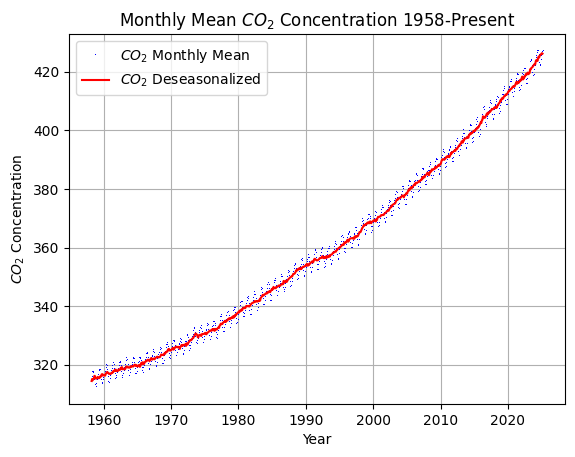

In [4]:
plt.plot(data["Decimal Date"], data["Monthly Mean CO2"],  'b,', label = r'$CO_2$ Monthly Mean')
plt.plot(data["Decimal Date"], data["De-seasonalized"], 'r-', label = r'$CO_2$ Deseasonalized')
plt.ylabel(r'$CO_2$ Concentration')
plt.xlabel('Year')
plt.title(r'Monthly Mean $CO_2$ Concentration 1958-Present')
plt.legend()
plt.grid()
plt.show()

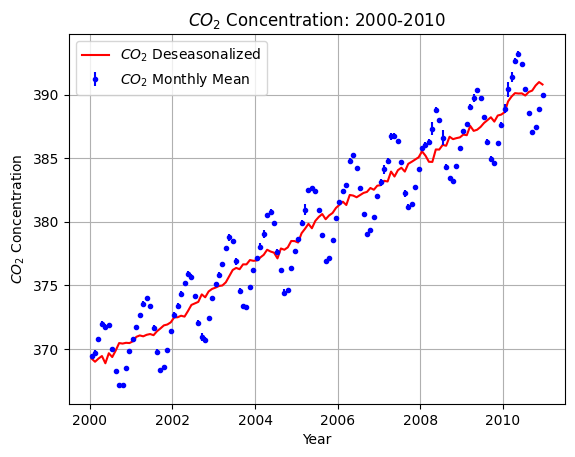

In [23]:
filtered_data = data[(data["Year"] >= 2000) & (data["Year"] <= 2010)].copy()

plt.plot(filtered_data["Decimal Date"],filtered_data["De-seasonalized"],'r-', label = r'$CO_2$ Deseasonalized')
plt.errorbar(filtered_data["Decimal Date"], filtered_data["Monthly Mean"], filtered_data["Uncertainty of Monthly Mean"], fmt = 'b.', label = r'$CO_2$ Monthly Mean')
plt.ylabel(r'$CO_2$ Concentration')
plt.xlabel('Year')
plt.title(r'$CO_2$ Concentrations: 2000-2010')
plt.legend()
plt.grid()
plt.show()

### C




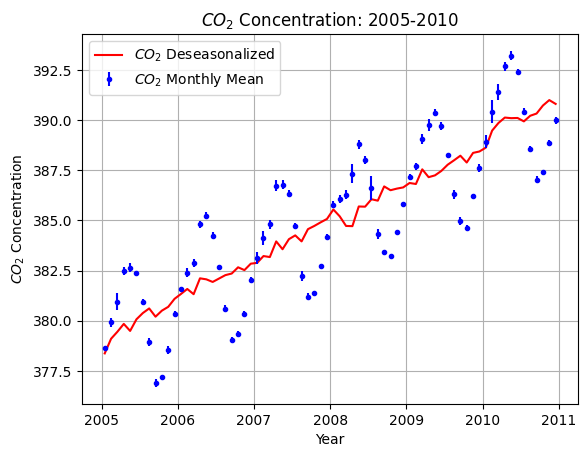

In [22]:
filtered_data_2 = data[(data["Year"] >= 2005) & (data["Year"] <= 2010)].copy()

plt.plot(filtered_data_2["Decimal Date"],filtered_data_2["De-seasonalized"],'r-', label = r'$CO_2$ Deseasonalized')
plt.errorbar(filtered_data_2["Decimal Date"], filtered_data_2["Monthly Mean"], filtered_data_2["Uncertainty of Monthly Mean"], fmt = 'b.', label = r'$CO_2$ Monthly Mean')
plt.ylabel(r'$CO_2$ Concentration')
plt.xlabel('Year')
plt.title(r'$CO_2$ Concentrations: 2005-2010')
plt.legend()
plt.grid()
plt.show()

Answer: The amplitude is around the midpoint of the y-axis. so, it's about 359.The source of the oscillation is the Keeling Curve. When you look at the data set, the error is typically lower around Co2 level 359.

### D

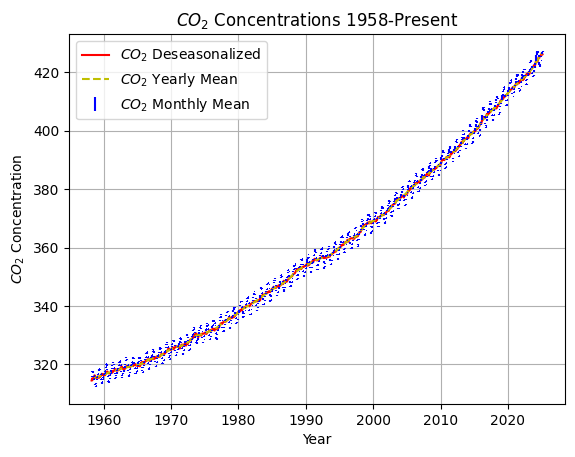

In [137]:
plt.plot(data["Decimal Date"], data["De-seasonalized"], 'r-', label = r'$CO_2$ Deseasonalized')
plt.plot(data["Yearly Mean Time"], data["Yearly Mean CO2"], 'y--', label = r'$CO_2$ Yearly Mean')
plt.errorbar(data["Decimal Date"], data["Monthly Mean CO2"], data["Monthly Mean Uncertainty"], fmt = 'b,', label = r'$CO_2$ Monthly Mean')
plt.ylabel(r'$CO_2$ Concentration')
plt.xlabel('Year')
plt.title(r'$CO_2$ Concentrations: 1958-Present')
plt.legend()
plt.grid()
plt.show()

Answer: As you can see in the plot above, the average Co2 levels that I calculated closely matches the Co2 Deseasonalized values.

## Part 2. Linear and Polynomial fits

### A

In [ ]:
def reduced_chi_sqr(Y, Y_err, Y_model, Params):
    """
    Calculate the reduced chi-squared statistic.
    
    Parameters:
    Y (array-like): Observed data.
    Y_err (array-like): Uncertainties in the observed data.
    Y_model (array-like): Model predictions.
    
    Returns:
    float: Reduced chi-squared statistic.
    """
    # Calculate the chi-squared statistic
    chi2 = np.sum(((Y - Y_model) / Y_err) ** 2)
    
    # Calculate the degrees of freedom
    dof = len(Y) - Params  # Number of data points minus number of parameters
    
    # Calculate the reduced chi-squared statistic
    return chi2 / dof if dof > 0 else np.inf



In [ ]:
from scipy.optimize import curve_fit
import numpy as np

def generalized_model(x, *params):
    """
    Generalized polynomial model with variable parameters.
    The number of parameters determines the degree of the polynomial.

    Parameters:
    - x: Independent variable (e.g., time or year)
    - *params: Coefficients of the polynomial (p0, p1, ..., pn)

    Returns:
    - The polynomial value for the given x and parameters.
    """
    return sum(p * x**i for i, p in enumerate(params))

def fit_model(X, Y, Y_error, initial_guesses):
    """
    Fits a generalized model to the data using curve_fit.

    Parameters:
    - X: Independent variable (e.g., time or year)
    - Y: Dependent variable (e.g., CO2 concentration)
    - Y_error: Uncertainty in Y
    - initial_guesses: Initial guesses for the parameters

    Returns:
    - params: Fitted parameters
    - uncertainties: Uncertainties in the fitted parameters
    - fitted_curve: The fitted curve values for X
    """
    # Fit the model using curve_fit
    params, covariance = curve_fit(
        generalized_model, X, Y, p0=initial_guesses, sigma=Y_error, absolute_sigma=True
    )
    uncertainties = np.sqrt(np.diag(covariance))  # Calculate uncertainties
    fitted_curve = generalized_model(X, *params)  # Generate the fitted curve
    
    return params, uncertainties, fitted_curve

In [112]:
def residuals(Y, Y_model):
    """
    Calculate the residuals between observed and model data.

    Parameters:
    - Y: Observed data
    - Y_model: Model predictions

    Returns:
    - Residuals (Y - Y_model)
    """
    return Y - Y_model

In [186]:
linearmodel = fit_model(data["Yearly Mean Time"], data["Yearly Mean CO2"], data["Yearly Mean Uncertainty"], [1,1])

plt.errorbar(data["Decimal Date"], data["Monthly Mean CO2"], yerr=data["Monthly Mean Uncertainty"], fmt='b,', label=r'$CO_2$ Monthly Mean')
plt.plot(data["Decimal Date"], data["De-seasonalized"],'r-', label = r'$CO_2$ Deseasonalized')
plt.plot(data["Year"], linearmodel[2], 'g-', label = r'Linear Model')
plt.title('Linear Model')
plt.xlabel('Years from 1958 to Present')
plt.ylabel(r'$CO_2$ Concentration')
plt.legend()
plt.grid()
plt.show()

reduced_chi_sqr_value = reduced_chi_sqr(data["Yearly Mean CO2"], data["Yearly Mean Uncertainty"], linearmodel[2], len(linearmodel[0]))

print("Reduced Chi-Squared Value:", reduced_chi_sqr_value)

SyntaxError: unterminated string literal (detected at line 14) (2782981046.py, line 14)

Answer: In the linear regression model, I used the standard formulas for finding $b_0$ and $b_1$ to formulate my guesses for the curve_fit model. This resulted in  curve_fit model finding the optimal parameters for the linear regression model. However, the linear regression model is not the optimal model for this data set. At the origin and end of the model it is not properly fitted to the data. Also, the chi square for the linear regression model is pretty high.

### B

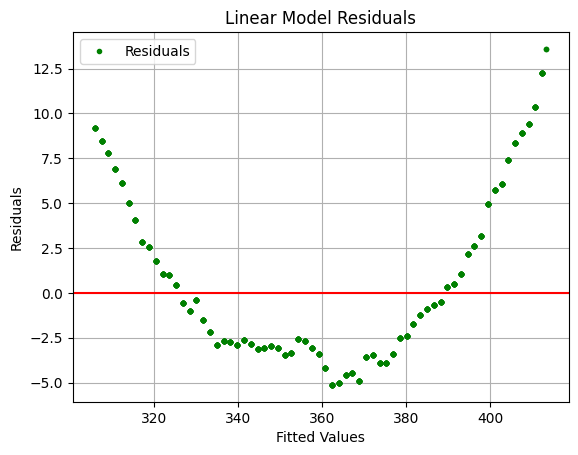

In [189]:
plt.plot(linearmodel[2],residuals(data["Yearly Mean CO2"], linearmodel[2]), 'g.', label = r'Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Linear Model Residuals')
plt.legend()
plt.grid()
plt.show()

Answer: The residuals here have a specific pattern, and are quadratic in shape. A good set of residuals are usually randomized, and have no specific pattern. Concurrently, it's best when a good portion of the residuals are clustered and spread across the 0 horizontal line. You don't see that here.

### C

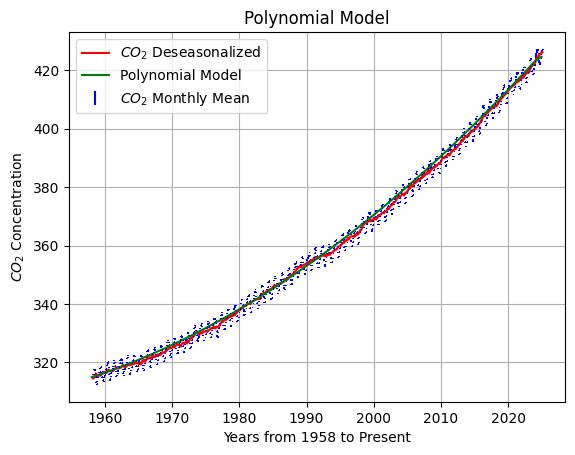

Reduced Chi-Squared Value: 15.747085416148346


In [188]:
polynomial_model = fit_model(data["Yearly Mean Time"], data["Yearly Mean CO2"], data["Yearly Mean Uncertainty"], [1, 1, 1])

plt.errorbar(data["Decimal Date"], data["Monthly Mean CO2"], yerr=data["Monthly Mean Uncertainty"], fmt='b,', label=r'$CO_2$ Monthly Mean')
plt.plot(data["Decimal Date"], data["De-seasonalized"],'r-', label = r'$CO_2$ Deseasonalized')
plt.plot(data["Year"], polynomial_model[2], 'g-', label = r'Polynomial Model')
plt.title('Polynomial Model')
plt.xlabel('Years from 1958 to Present')
plt.ylabel(r'$CO_2$ Concentration')
plt.legend()
plt.grid()
plt.show()

reduced_chi_sqr_value = reduced_chi_sqr(data["Yearly Mean CO2"], data["Yearly Mean Uncertainty"], polynomial_model[2], len(polynomial_model[0]))

print("Reduced Chi-Squared Value:", reduced_chi_sqr_value)

Answer: This polynomial regression model is a significant improvement from the linear regression model. It's properly fitted to the data and has a much lower reduced chi square.

### D

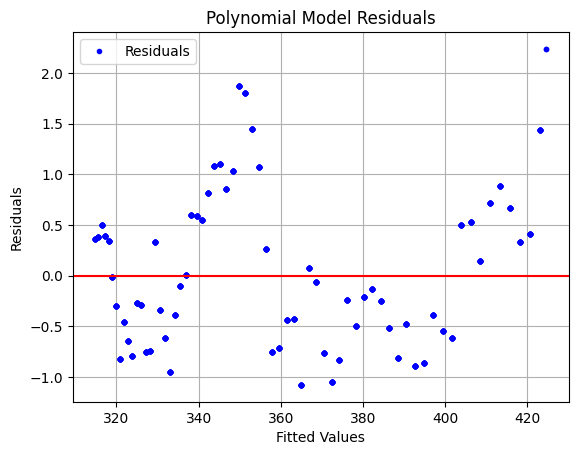

In [190]:
plt.plot(polynomial_model[2],residuals(data["Yearly Mean CO2"], polynomial_model[2]), 'b.', label = r'Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Polynomial Model Residuals')
plt.legend()
plt.grid()
plt.show()

Answer: This is a good set of residuals here. They are randomized, and a decent portion of them are clustered and spread across the 0 horizontal line. Overall, they are superior to the residuals in the linear regression model.  

### E

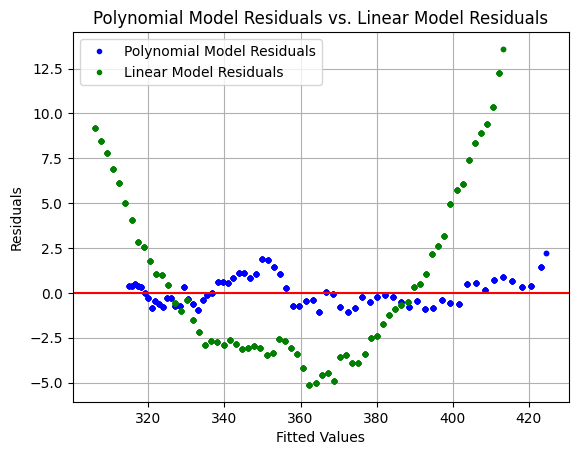

In [144]:
plt.plot(polynomial_model[2],residuals(data["Yearly Mean CO2"], polynomial_model[2]), 'b.', label = r'Polynomial Model Residuals')
plt.plot(linearmodel[2],residuals(data["Yearly Mean CO2"], linearmodel[2]), 'g.', label = r'Linear Model Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Polynomial Model Residuals vs. Linear Model Residuals')
plt.legend()
plt.grid()
plt.show()

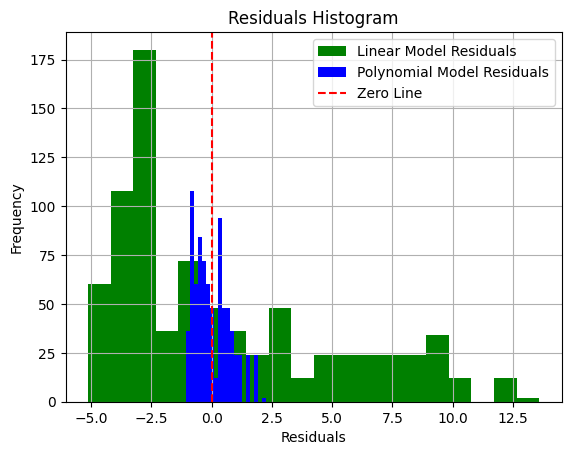

In [148]:
plt.hist(residuals(data["Yearly Mean CO2"], linearmodel[2]), color="green", bins=20, label='Linear Model Residuals')    
plt.hist(residuals(data["Yearly Mean CO2"], polynomial_model[2]), color="blue", bins=20, label='Polynomial Model Residuals')
plt.axvline(x=0, color='r', linestyle='--', label='Zero Line')
plt.xlabel('Residuals')     
plt.ylabel('Frequency')
plt.title('Residuals Histogram')        
plt.legend()
plt.grid()
plt.show()

Answer: It's very obvious when you compare the two residuals plots that the quadratic regression residuals are better. The linear regression residuals have a distinct quadratic pattern to them. Residuals are supposed to be random in behavior. That random behavior in the quadratic regression residuals is evident. Also, when you compare the reduced chi-squared for each model, notice that the quadratic regression model has a much lower reduced chi-squared. Therefore, the quadratic regression model is superior to the linear regression model.

## Part 3. Projecting future CO2 levels

### A

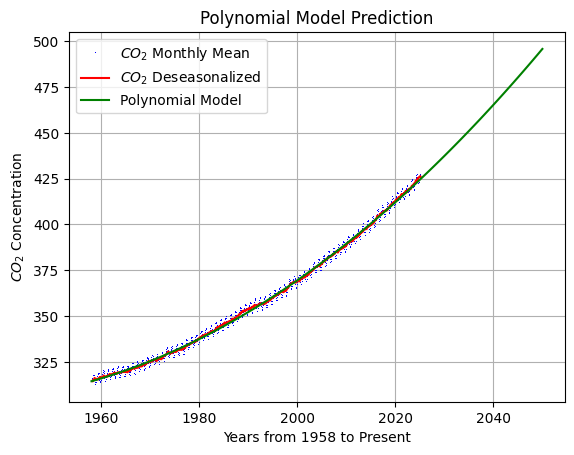

Predicted CO2 concentration for the year 2050: 495.79 ppm


In [178]:
polynomial_model = fit_model(data["Yearly Mean Time"], data["Yearly Mean CO2"], data["Yearly Mean Uncertainty"], [1, 1, 1])

Year_Predicted = np.arange(data["Year"].min(),2051,1)
predictions = generalized_model(Year_Predicted, *polynomial_model[0])

plt.plot(data["Decimal Date"], data["Monthly Mean CO2"], 'b,', label = r'$CO_2$ Monthly Mean')
plt.plot(data["Decimal Date"], data["De-seasonalized"],'r-', label = r'$CO_2$ Deseasonalized')
plt.plot(Year_Predicted, predictions, 'g-', label = r'Polynomial Model')
plt.title('Polynomial Model Prediction')
plt.xlabel('Years from 1958 to Present')
plt.ylabel(r'$CO_2$ Concentration')
plt.legend()
plt.grid()
plt.show()
print(f"Predicted CO2 concentration for the year {Year_Predicted[-1]}: {predictions[-1]:.2f} ppm")

Answer: From what what you can see, the quadratic regression maintains a closer fit to the data and it has a lower reduced chi square. As a result, it's predictions are more accurate than the linear regression. It predicts a higher average Co2 level occurring in 2050.